In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sub_act import sub_input, sub_process
from utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
vol_file = Path('../Voltron_data/Voltron_Log_DRN_Exp.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
# using Path to handle switches filesystems
if platform == "linux" or platform == "linux2":
    dir_folder = Path('/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/')
elif platform == 'win32':
    dir_folder = Path('U:\\Takashi') # put folder for windows system

vol_file = Path('depreciated/analysis_opto_based_on_swim_pattern.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')

### High-low gain activity in swim bouts -- subvolt

In [27]:
ave_low_list = []
ave_high_list = []
row_ = 0
for __, row in dat_xls_file.iterrows():
    folder = row['folder']
    fish = row['fish']
    if 'Optovin' not in row['task']:
        continue    
    dat_dir = dir_folder/f'{folder}/{fish}/Data/'
    swim_dir = dir_folder/f'{folder}/{fish}/swim/'
    if not os.path.exists(dat_dir/'Voltr_spikes.npz'):
        continue
    dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
    dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
    spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
    num_cell = spk.shape[0]
    # spk with padding zeros for the first 2 seconds
    spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
    frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')

    _ = np.load(f'swim_power/{folder}_{fish}_swim_dat.npz')
    swim_starts = _['swim_starts']
    swim_ends = _['swim_ends']
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    visu = _['visu']
    p_swim = np.sqrt(r_swim**2+l_swim**2)
    
    task_period = frame_stimParams[2,swim_starts] # 1, low; 2 high
    task_period = task_period + frame_stimParams[3,swim_starts]*2 -2 # 
    opto_ = frame_stimParams[5]
    opto_t = np.where(opto_)[0]
    for n_ in range(len(swim_starts)):
        if (swim_starts[n_]>opto_t).sum() == 0:
            continue
        if swim_starts[n_] - opto_t[swim_starts[n_]>opto_t][-1]<10*300:
            task_period[n_] = task_period[n_] + 2
        if swim_starts[n_] - opto_t[swim_starts[n_]>opto_t][-1]<300:
            task_period[n_] = 0
        if (swim_starts[n_]<opto_t).sum() == 0:
            continue
        if swim_starts[n_] - opto_t[swim_starts[n_]<opto_t][0]>-300:
            task_period[n_] = 0
            
    count_, _ = np.histogram(task_period, bins=range(8))
    if count_[1]<100:
        continue
    spk = sub_process(dff, k_size=51)
    print([folder, fish])
    
    win_size = 3
    first_swim_bout_index = [np.where((task_period[:-1]!=5) & (task_period[1:]==5))[0]+1]
    first_swim_bout_index.append(np.where((task_period[:-1]!=6) & (task_period[1:]==6))[0]+1)
    
    if win_size > 1:
        first_swim_bout_index[0] = np.concatenate([first_swim_bout_index[0]+_ for _ in range(win_size)])
        first_swim_bout_index[0] = first_swim_bout_index[0][first_swim_bout_index[0]<len(task_period)]
        first_swim_bout_index[1] = np.concatenate([first_swim_bout_index[1]+_ for _ in range(win_size)])
        first_swim_bout_index[1] = first_swim_bout_index[1][first_swim_bout_index[1]<len(task_period)]
    
    for clip_index in first_swim_bout_index:
        task_period[clip_index] = 0
    
    for n_cell in range(spk.shape[0]):
        spk_list = np.zeros((r_swim.shape[0], 400))
        remove_list = np.zeros(r_swim.shape[0]).astype('bool')
        for n, n_swim in enumerate(swim_starts):
            try:
                spk_list[n, :] = spk[n_cell, n_swim-100:n_swim+300] - spk[n_cell, n_swim-50:n_swim].mean()
            except:
                remove_list[n]=True
        spk_list = spk_list[~remove_list, :]
        _ = []
        for n_ in range(6):
            ave_ = spk_list[task_period==n_+1].mean(axis=0)
            _.append(ave_)
        for n_ in range(2):
            ave_ = spk_list[first_swim_bout_index[n_]].mean(axis=0)
            _.append(ave_)
        ave_low_list.append(_[0::2])
        ave_high_list.append(_[1::2])

['01242019', 'Fish2-1']
['01242019', 'Fish2-2']
['01312019', 'Fish3-1']
['01312019', 'Fish3-3']
['02142019', 'Fish2-4']
['02142019', 'Fish2-5']
['02142019', 'Fish2-6']


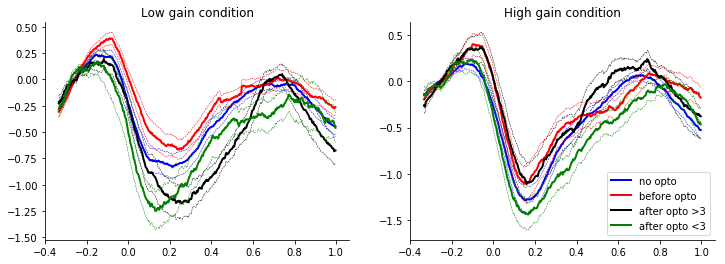

In [33]:
ave_low_list_ = np.array(ave_low_list)
ave_high_list_ = np.array(ave_high_list)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

line_spec = ['b', 'r', 'k', 'g']
labels = ['no opto', 'before opto', f'after opto >{win_size}', f'after opto <{win_size}']

act_list = ave_low_list_
act_list = act_list - act_list[:, :, :50].mean(axis=-1, keepdims=True)
norm_ff = np.std(act_list, axis=(1,2), keepdims=True)
# norm_ff = 1
act_list = act_list/norm_ff
ave_act = np.array(act_list).mean(axis=0)
sem_act = np.array(act_list).std(axis=0)/np.sqrt(len(act_list))
for n_ in range(4):
    ax[0].plot(np.arange(400)/300 - 100/300, ave_act[n_], f'-{line_spec[n_]}', lw=2, label=labels[n_])
    ax[0].plot(np.arange(400)/300 - 100/300, ave_act[n_]+sem_act[n_], f'--{line_spec[n_]}', lw=0.5)
    ax[0].plot(np.arange(400)/300 - 100/300, ave_act[n_]-sem_act[n_], f'--{line_spec[n_]}', lw=0.5)
# ax[0].set_xlim([-0.2, 0.8])
ax[0].set_title('Low gain condition')
sns.despine()

act_list = ave_high_list_
act_list = act_list - act_list[:, :, :50].mean(axis=-1, keepdims=True)
act_list = act_list/norm_ff
ave_act = np.array(act_list).mean(axis=0)
sem_act = np.array(act_list).std(axis=0)/np.sqrt(len(act_list))
for n_ in range(4):
    ax[1].plot(np.arange(400)/300 - 100/300, ave_act[n_], f'-{line_spec[n_]}', lw=2, label=labels[n_])
    ax[1].plot(np.arange(400)/300 - 100/300, ave_act[n_]+sem_act[n_], f'--{line_spec[n_]}', lw=0.5)
    ax[1].plot(np.arange(400)/300 - 100/300, ave_act[n_]-sem_act[n_], f'--{line_spec[n_]}', lw=0.5)
# ax[1].set_xlim([-0.2, 0.8])
ax[1].set_title('High gain condition')
sns.despine()
plt.legend()
plt.show()

### Cell-by-cell plots

In [34]:
# for n_cell in range(act_list.shape[0]):
#     fig, ax = plt.subplots(1, 2, figsize=(12, 4))
#     act_list = ave_low_list_
#     norm_ff = 1 #np.std(act_list, axis=(1,2), keepdims=True)
#     act_list = act_list/norm_ff
#     ave_act = np.array(act_list[n_cell])
#     for n_ in range(4):
#         ax[0].plot(np.arange(400)/300 - 100/300, ave_act[n_], f'-{line_spec[n_]}', lw=2, label=labels[n_])
#     ax[0].set_xlim([-0.2, 0.8])
#     ax[0].set_title('Low gain condition')
#     sns.despine()

#     act_list = ave_high_list_
#     # act_list = act_list - act_list[:, :, :100].mean(axis=-1, keepdims=True)
#     act_list = act_list/norm_ff
#     ave_act = np.array(act_list[n_cell])
#     for n_ in range(4):
#         ax[1].plot(np.arange(400)/300 - 100/300, ave_act[n_], f'-{line_spec[n_]}', lw=2, label=labels[n_])
#     ax[1].set_xlim([-0.2, 0.8])
#     ax[1].set_title('High gain condition')
#     sns.despine()
#     plt.legend()
#     plt.show()

### Neural trace by task epochs

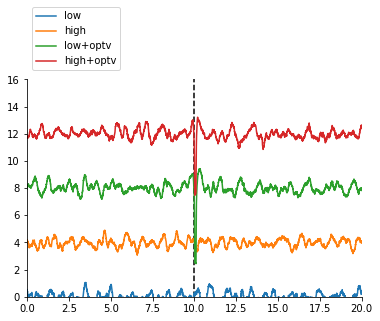

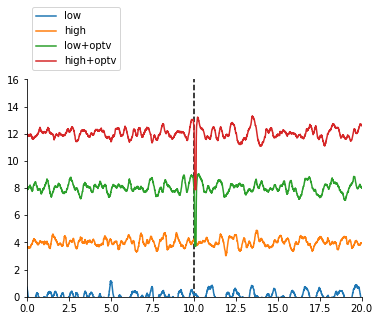

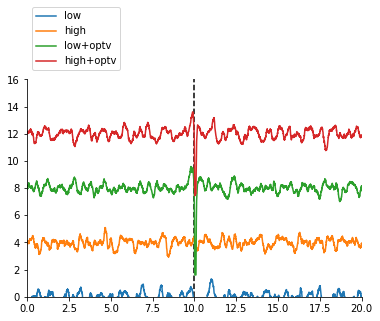

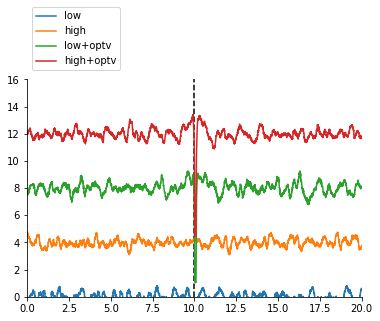

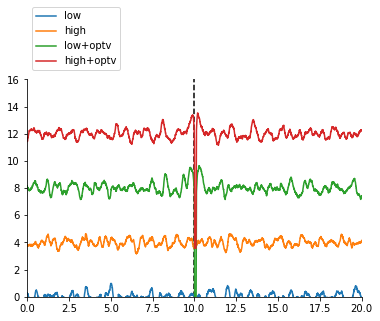

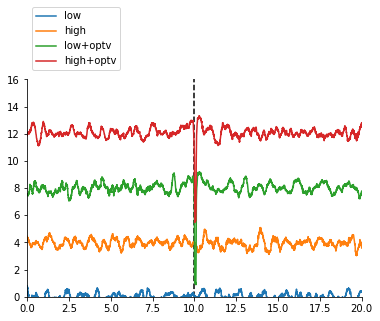

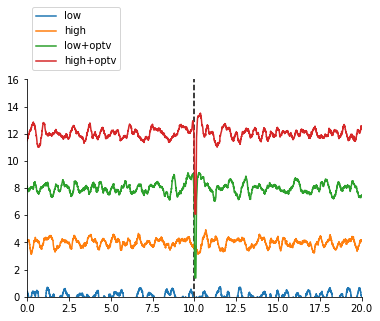

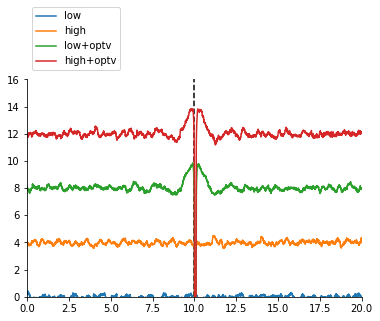

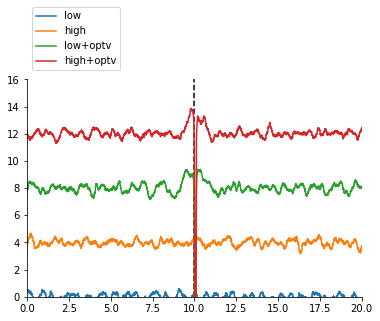

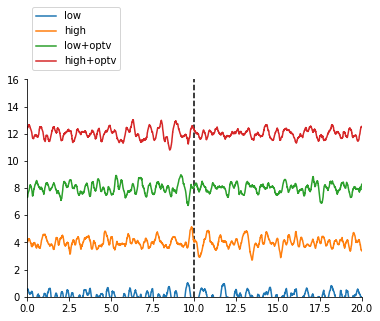

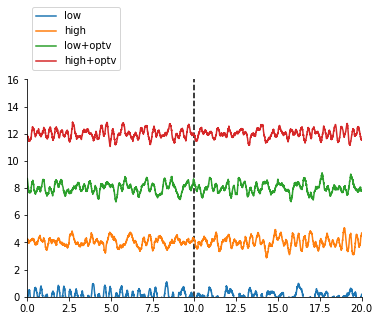

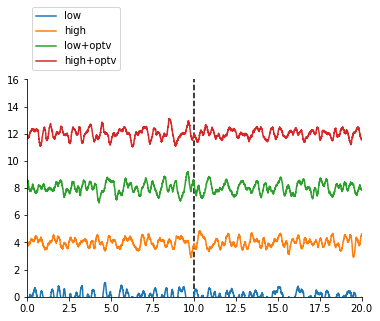

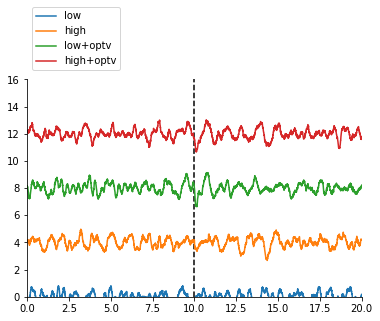

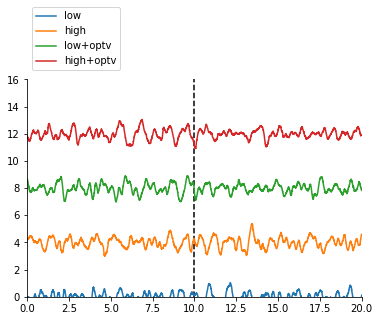

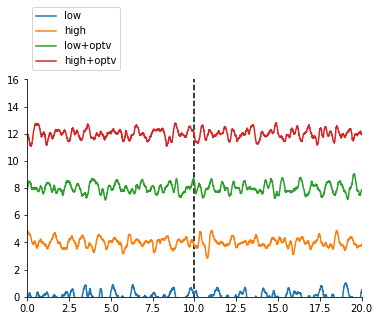

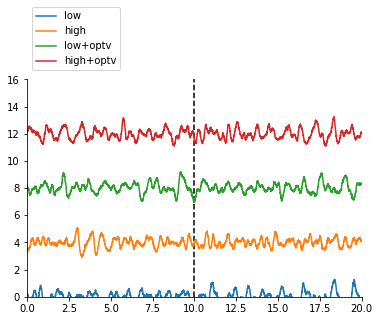

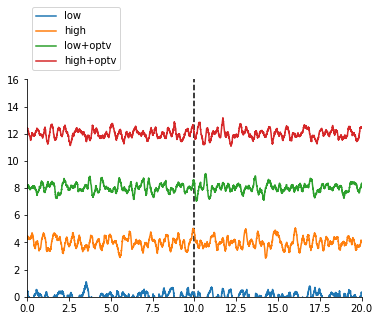

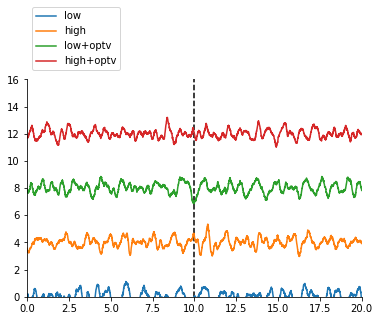

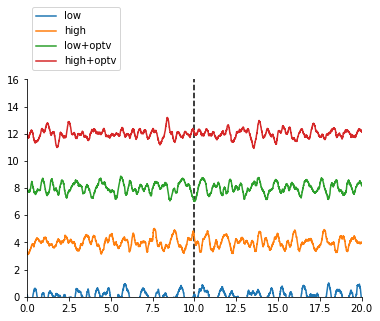

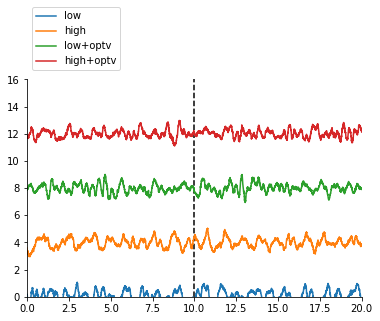

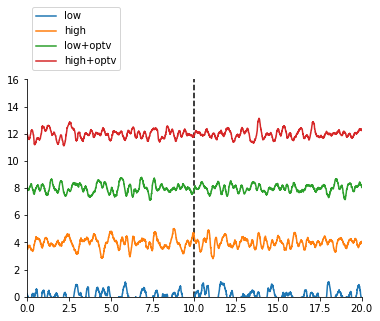

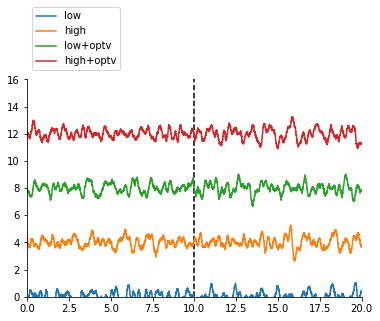

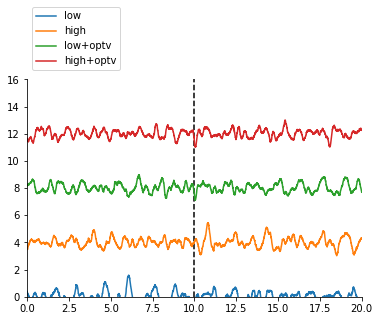

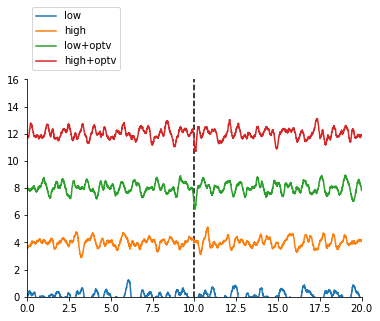

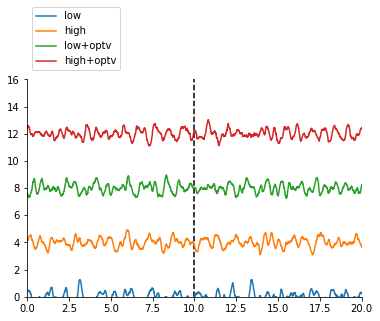

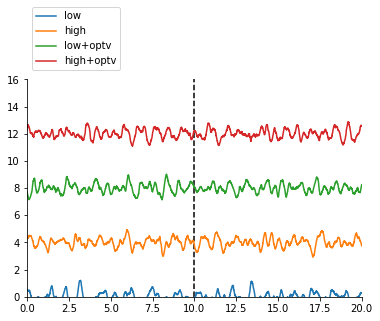

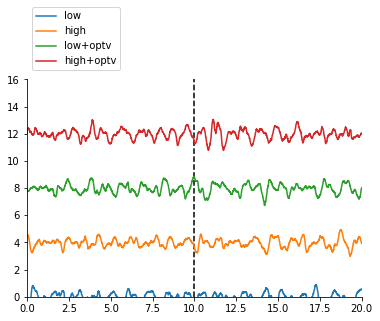

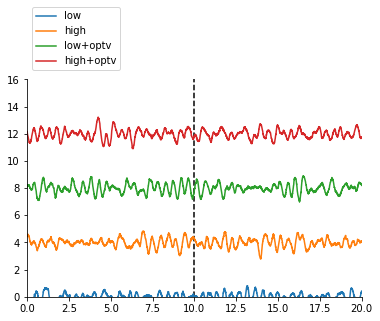

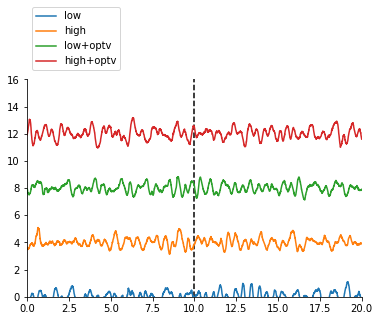

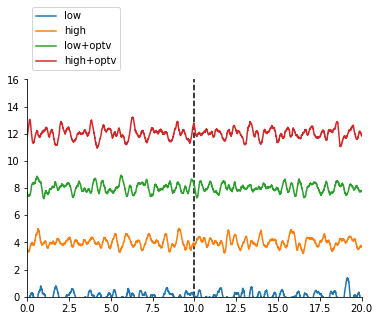

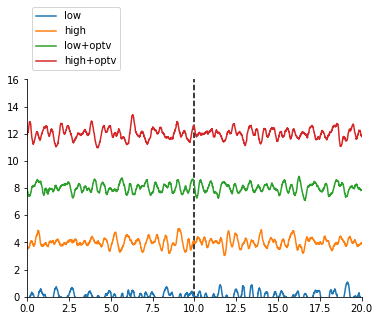

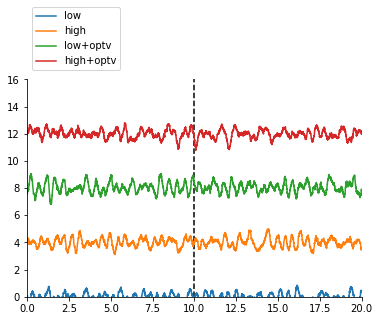

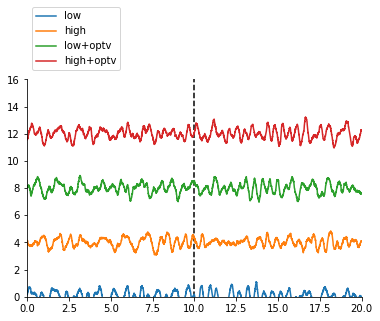

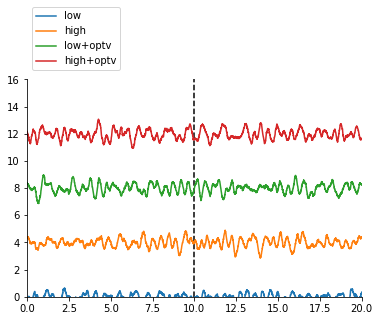

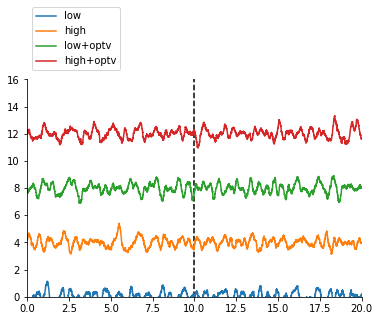

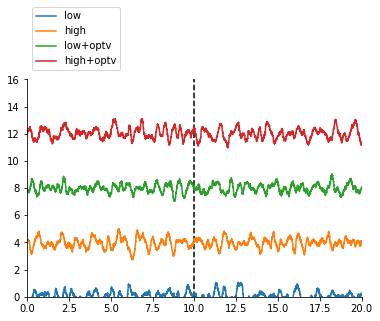

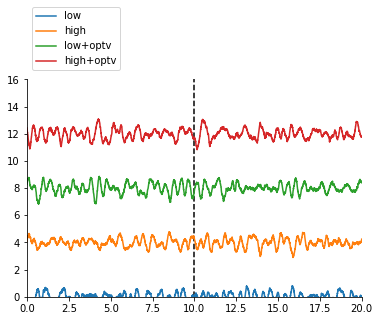

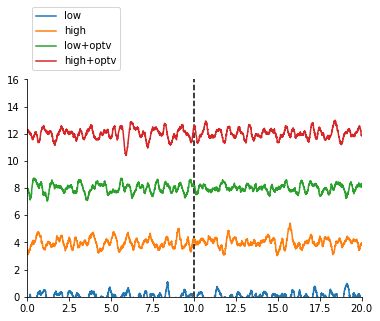

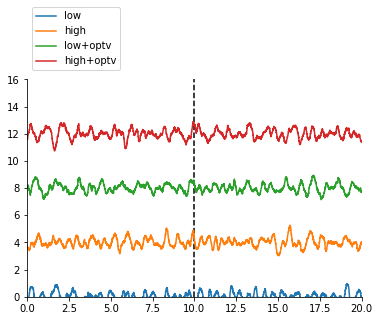

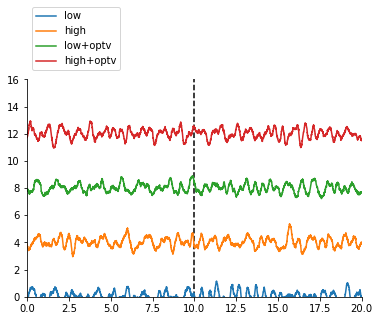

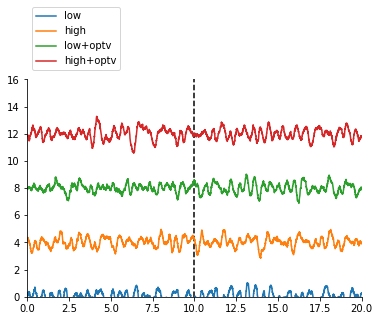

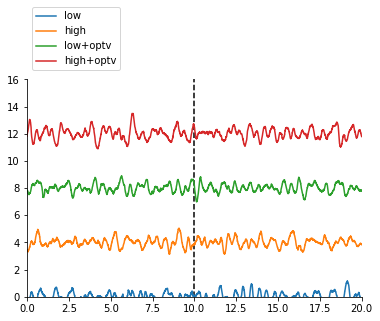

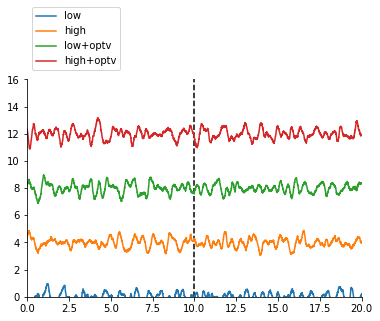

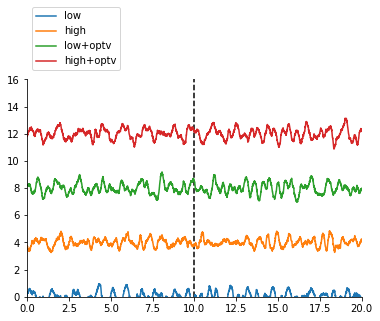

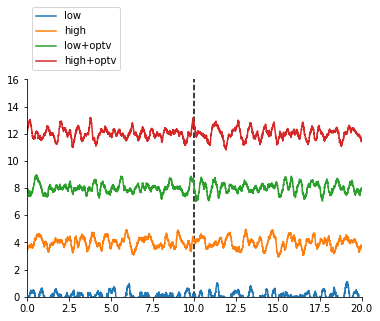

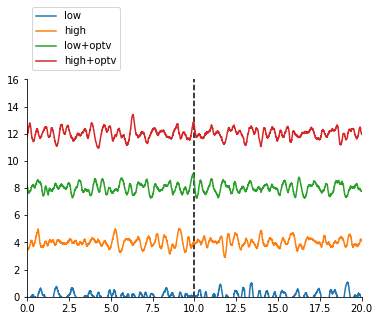

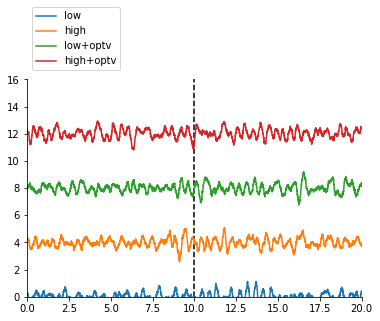

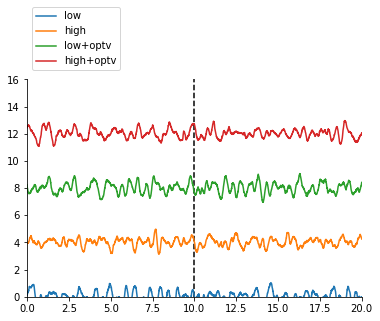

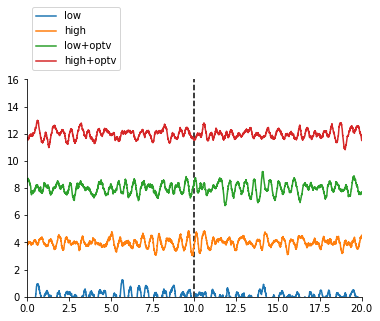

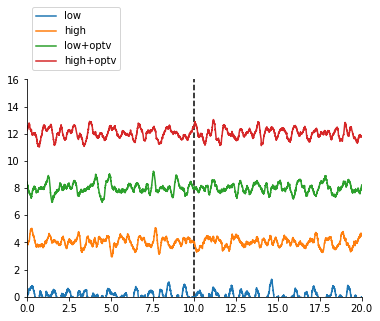

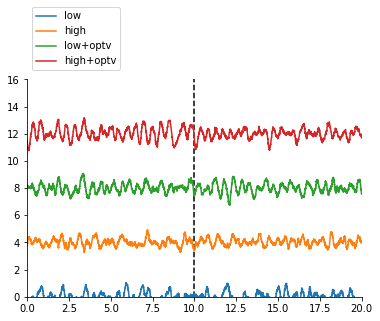

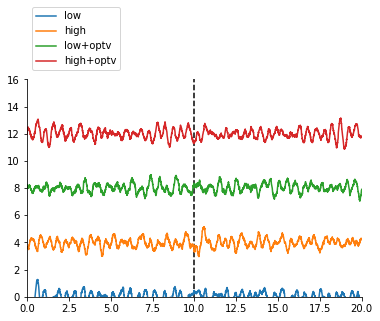

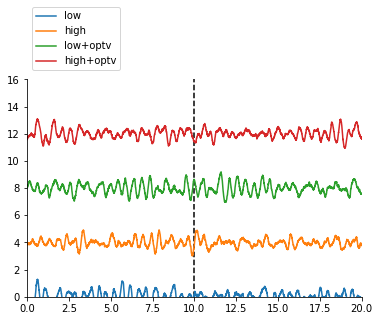

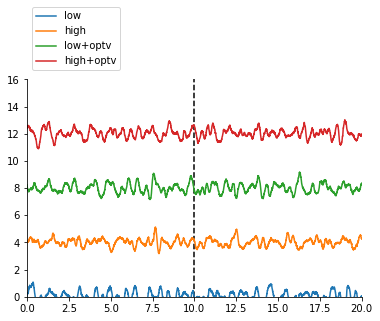

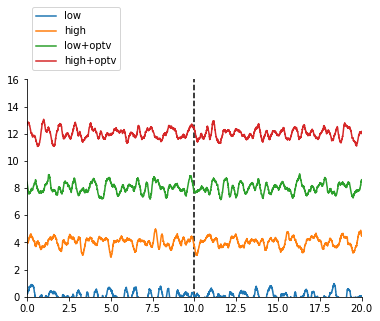

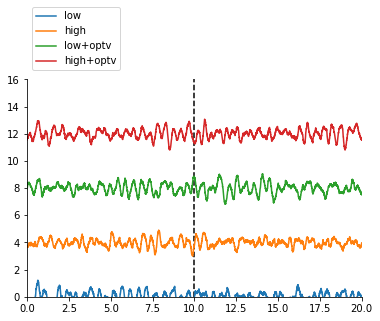

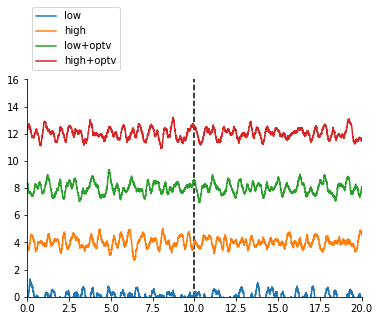

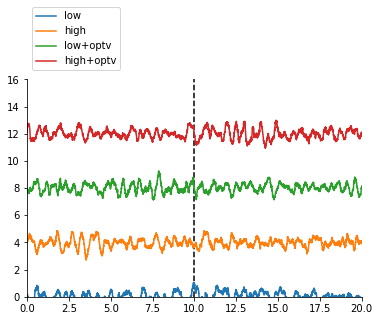

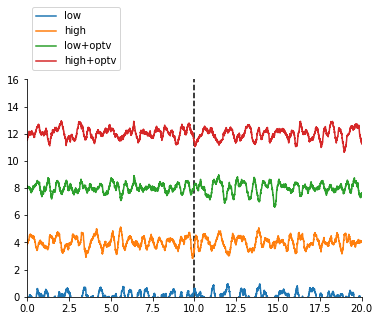

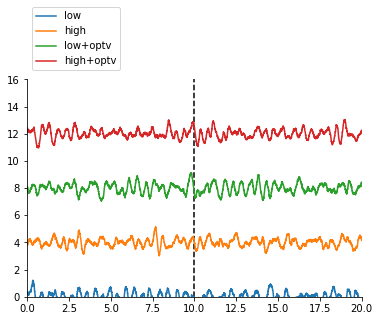

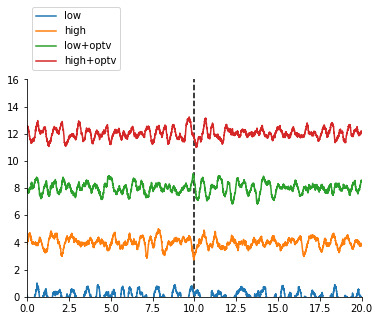

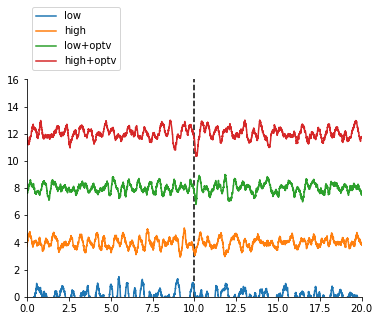

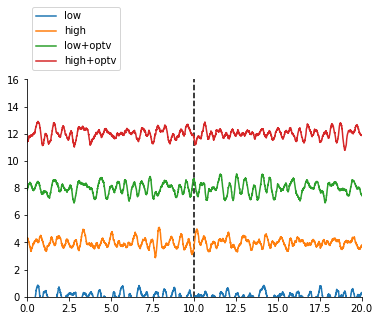

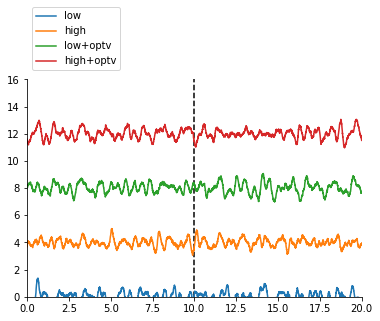

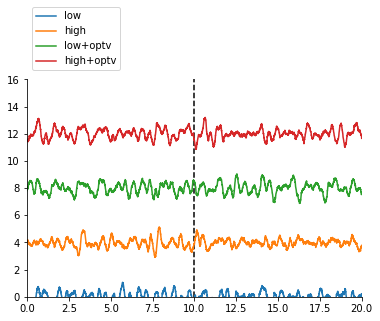

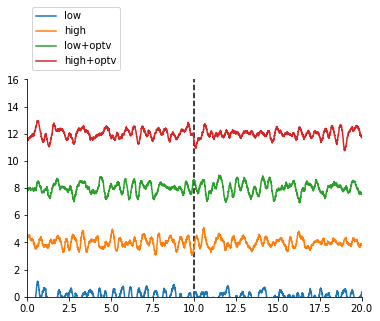

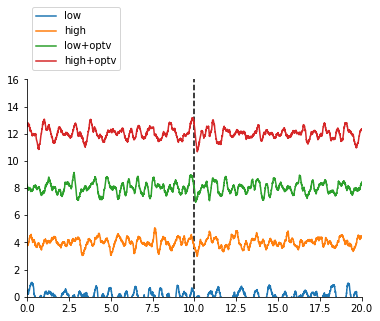

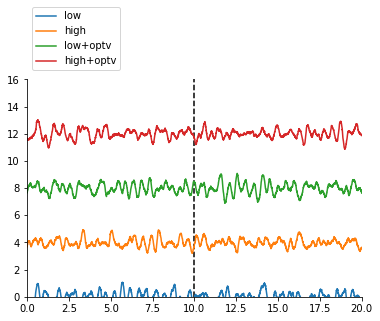

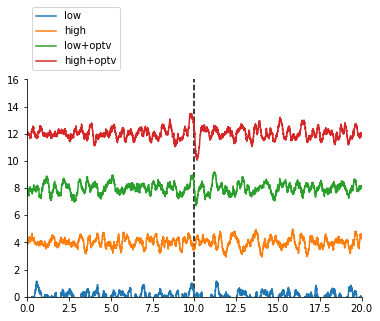

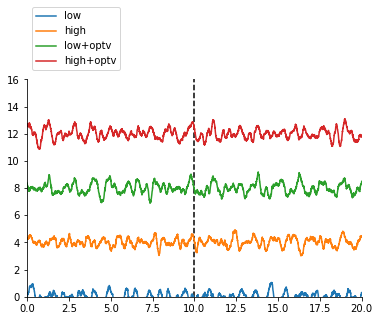

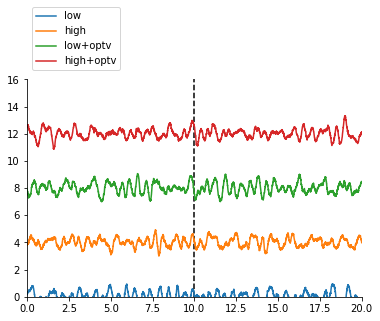

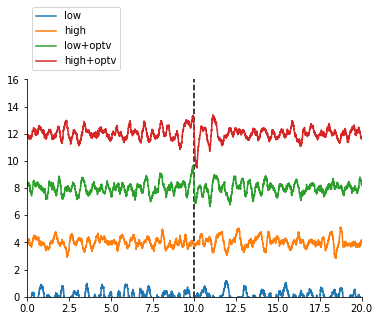

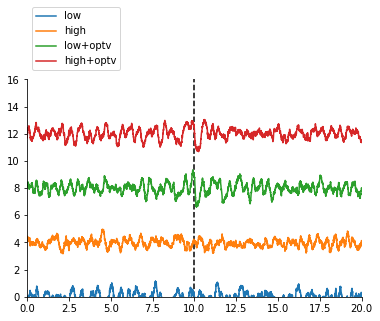

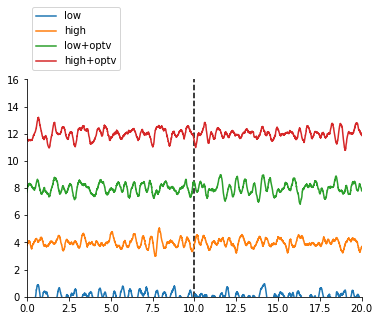

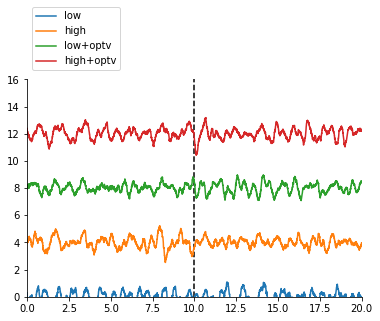

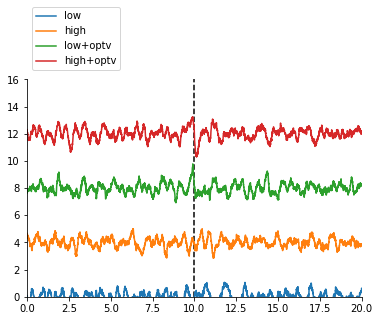

In [40]:
k_ = boxcarKernel(sigma=100)
ave_low_list = []
ave_high_list = []
row_id = -1
is_plot = True
for _, row in dat_xls_file.iterrows():
    folder = row['folder']
    fish = row['fish']
    row_id = row_id+1
    if 'Optovin' not in row['task']:
        continue
    dat_dir = dir_folder/f'{folder}/{fish}/Data/'
    swim_dir = dir_folder/f'{folder}/{fish}/swim/'
    dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
    dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
    spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
    num_cell = spk.shape[0]
    # spk with padding zeros for the first 2 seconds
    spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
    frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')
    gain_ = frame_stimParams[2]
    opto_ = frame_stimParams[5]
    opto_t = np.where(opto_)[0]
    win_size = 4
    for win_ in range(-win_size, win_size+1):
        spk[:, opto_t+win_]=0
    opto_epoch = frame_stimParams[3]
    trial_ = frame_stimParams[4]
    if spk.shape[-1]>len(trial_):
        trial_ = np.concatenate([trial_, np.zeros(spk.shape[-1]-len(trial_))])
    else:
        trial_ = trial_[:spk.shape[-1]]
    num_trial = trial_.max().astype('int')-1
    spk = sub_process(dff, k_size=51)
    spk = spk/spk.std(axis=-1, keepdims=True)
    for n_cell in range(spk.shape[0]):
        spk_list = []
        for ntrial in range(num_trial):
            spk_list.append(spk[n_cell, trial_==ntrial+1])
        trial_len = min([_.shape for _ in spk_list])[0]
        spk_list_ = np.vstack([_[:trial_len] for _ in spk_list])
        k_ = boxcarKernel(sigma=100)
        ave_ = spk_list_.mean(axis=0)
        epoch_len = trial_len//4
        labels = ['low', 'high', 'low+optv', 'high+optv']
        if not is_plot:
            continue
        for n_epoch in range(4):
            ave_smooth = ave_[n_epoch*epoch_len:(n_epoch+1)*epoch_len]
            plt.plot(np.arange(epoch_len)/300, ave_smooth+4*n_epoch, label=labels[n_epoch])
        plt.vlines([10], [0], [16], linestyles='--', color='k')
        plt.xlim([0, epoch_len/300])
        plt.ylim([0, 16])
        sns.despine()
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3)
        plt.show()

In [ ]:
is_plot = False
k_ = boxcarKernel(sigma=100)
# row_ = -1
# cell_id = 1
# row = dat_xls_file.iloc[row_]
for _, row in dat_xls_file.iterrows():
    folder = row['folder']
    fish = row['fish']
    if 'Optovin' not in row['task']:
        continue
    dat_dir = dir_folder/f'{folder}/{fish}/Data/'
    swim_dir = dir_folder/f'{folder}/{fish}/swim/'
    dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
    dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
    spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
    num_cell = spk.shape[0]
    # spk with padding zeros for the first 2 seconds
    spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
    frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')
    gain_ = frame_stimParams[2]
    opto_ = frame_stimParams[5]
    opto_t = np.where(opto_)[0]
    win_size = 4
    for win_ in range(-win_size, win_size+1):
        spk[:, opto_t+win_]=0
    opto_epoch = frame_stimParams[3]
    trial_ = frame_stimParams[4]
    if spk.shape[-1]>len(trial_):
        trial_ = np.concatenate([trial_, np.zeros(spk.shape[-1]-len(trial_))])
    else:
        trial_ = trial_[:spk.shape[-1]]
    num_trial = trial_.max().astype('int')-1

    for n_cell in range(spk.shape[0]):
    #     if n_cell != cell_id:
    #         continue
        spk_list = np.zeros((r_swim.shape[0], 400))
        remove_list = np.zeros(r_swim.shape[0]).astype('bool')
        for n, n_swim in enumerate(swim_starts):
            try:
                spk_list[n, :] = spk[n_cell, n_swim-100:n_swim+300]
            except:
                remove_list[n]=True
        spk_list = spk_list[~remove_list, :]
        _ = []
        for n_ in range(6):
            ave_ = spk_list[task_period==n_+1].mean(axis=0)*300
            _.append(smooth(ave_, k_))
        if not is_plot:
            continue
        fig, ax = plt.subplots(1, 2)
        ax[0].plot(np.array(_[0::2]).T)
        ax[1].plot(np.array(_[1::2]).T)
        plt.show()